# Annotation analysis
Here, we calculate stats for evaluation the annotation quality.  Specifically, percentage (N) of agreement as well as kappa (K) are calculate

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

matplotlib.style.use('seaborn-paper')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['legend.fontsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['axes.titlesize'] = 18

In [2]:
ds = pd.read_csv('data/wdds.csv')
ds.shape

(2097, 20)

In [3]:
ds = ds[~ds.type.isnull()]
ds.shape

(1583, 20)

let's look at the column that indicates the opinion type according to the taxonomy defined in the literature.

In [4]:
labeldist=ds[['row_id','type']].groupby('type').size().reset_index()
labeldist.columns = ['type', 'N']
total = labeldist['N'].sum()
labeldist['perc'] = labeldist['N'] / total
labeldist

,type,N,perc
0,ARGUMENTATIVE,773,0.488313
1,INTERPERSONAL,149,0.094125
2,PERFORMATIVE,661,0.417562


Now, we are going to analyze if there are different labels in each turn (the whole edit made by an author, generally a paragraph)

In [5]:
lblfield='subtype'
lblturns = ds.groupby(['page_id', 'turn']).agg({lblfield:pd.Series.nunique})
lblturns = lblturns.reset_index()
turns = lblturns.groupby(lblfield).count().reset_index()
total = turns.page_id.sum()
turns['perc'] = turns.page_id/float(total)
turns = turns[[lblfield, 'perc']]
turns.columns = ['Number of labels', 'Percentage']
turns.to_csv('output/labelsturnsdist.csv', index=False)
turns

,Number of labels,Percentage
0,1,0.651952
1,2,0.222411
2,3,0.093379
3,4,0.025467
4,5,0.005093
5,6,0.001698


In [6]:
ds.sample(2, random_state=3)

,row_id,page_id,page_title,contributor,timestamp,creation_dt,topic,opinion,clean_opinion,turn,segmentation,type,subtype,type_r1,subtype_r1,type_r2,subtype_r2,stance,sentiment,url
343,8,1812320,Hugo Chávez,Negrocoriano,1423507040,2/9/15 18:37,estado de salud de hugo chávez,"además, resulta muy extraño y ajeno que las no...","además, resulta muy extraño y ajeno que las no...",6,OK,PERFORMATIVE,IP,NaN,NaN,NaN,NaN,NaN,NaN,https://es.wikipedia.org/wiki/Discusión:Hugo_C...
1852,55,310503,Cristina Fernández de Kirchner,LMLM,1204916341,3/7/08 18:59,título de abogado,un saludo.,un saludo.,28,OK,INTERPERSONAL,ATT,NaN,NaN,NaN,NaN,NaN,NaN,https://es.wikipedia.org/wiki/Discusión:Cristi...


## agreement

In [7]:
ds = ds[ds.subtype!='INVALID']
ds = ds[ds.subtype!='SIGN']

In [8]:
from sklearn.metrics import cohen_kappa_score

labels = ds.subtype.unique()
print(f'num labels:{ len(labels)}')

lblfield = 'subtype'
label_f1 = 'subtype_r1'
label_f2 = 'subtype_r2'
aggree_r1 = 'agreement_r1'
aggree_r2 = 'agreement_r2'
aggreement = 'po'
agreement_expected = 'pe'
rndlbl_r1 = 'rndlbl_r1'
rndlbl_r2 = 'rndlbl_r2'
# N
ds[aggree_r1] = ds[lblfield] == ds[label_f1]
ds[aggree_r2] = ds[lblfield] == ds[label_f2]
ds[aggreement] = ds[aggree_r1] & ds[aggree_r2]
# kappa
ds[rndlbl_r1] = ds.subtype.sample(ds.shape[0], random_state=4).values
ds[rndlbl_r2] = ds.subtype.sample(ds.shape[0], random_state=5).values
ds[agreement_expected] = ds[rndlbl_r1] == ds[rndlbl_r2] 

ds[aggreement] = ds[aggreement].apply(lambda x: float(x))
ds[agreement_expected] = ds[agreement_expected].apply(lambda x: float(x))
ds_rs = ds.groupby(lblfield).agg({'row_id': 'count',
                                  aggreement: 'mean',
                                  agreement_expected:'mean'})
ds_rs = ds_rs.reset_index()
ds_rs.columns=['subtype','N', aggreement,agreement_expected]
#ds_rs['kappa'] = cohen_kappa_score(ds[label_f1], ds[label_f2], labels)
ds_rs['kappa'] = (ds_rs[aggreement] - ds_rs[agreement_expected])/(1-ds_rs[agreement_expected])
ds_rs.to_csv('output/agreement.csv', index=False)
ds_rs

num labels:17


,subtype,N,po,pe,kappa
0,ACE,3,0.0,0.000000,0.000000
1,ATT,147,0.0,0.251701,-0.336364
2,ATT-,2,0.0,0.000000,0.000000
3,CL,11,0.0,0.090909,-0.100000
4,CM,57,0.0,0.105263,-0.117647
5,CO,582,0.0,0.214777,-0.273523
6,COBJ,28,0.0,0.107143,-0.120000
7,CS,20,0.0,0.150000,-0.176471
8,CU,36,0.0,0.222222,-0.285714
9,CW,36,0.0,0.277778,-0.384615


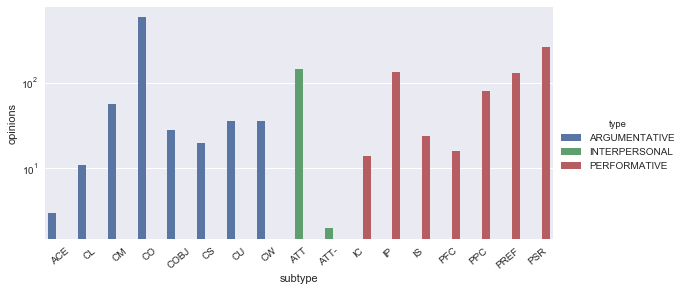

In [9]:
import seaborn
typedist=ds[['row_id','type','subtype']].groupby(['type', 'subtype']).count()
typedist.reset_index(inplace=True)
plt.figure(figsize=(15,3))
fg = seaborn.factorplot(x='subtype', y='row_id', hue='type', 
                        data=typedist, kind='bar', size=4, aspect=2)
fg.set_xticklabels(rotation=40)
plt.yscale('log')
plt.ylabel('opinions')
plt.savefig('output/annotatedopinionsdist.eps', format='eps')